In [1]:
import pandas as pd
import yfinance as yf
import backtrader as bt 

In [2]:
hist_price= yf.download('TCS.NS', start_date = '2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data=hist_price.sort_index()[-253:]

In [4]:
data = bt.feeds.PandasData( dataname=data)

In [5]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        if self.dataclose[0] < self.dataclose[-1]:
            if self.dataclose[-1] < self.dataclose[-2]:
              
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()

In [86]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

In [87]:
cerebro = bt.Cerebro()
cerebro.adddata(data)

In [88]:
cerebro.addstrategy(TestStrategy)

0

In [82]:
#cerebro.broker.setcommission(commission=0.001)


In [89]:
cerebro.run()

2021-11-15, Close, 3556.40
2021-11-16, Close, 3521.90
2021-11-17, Close, 3475.70
2021-11-17, BUY CREATE, 3475.70
2021-11-21, BUY EXECUTED, 3478.40
2021-11-21, Close, 3458.40
2021-11-22, Close, 3464.25
2021-11-23, Close, 3443.30
2021-11-24, Close, 3445.90
2021-11-25, Close, 3446.85
2021-11-28, Close, 3502.00
2021-11-28, SELL CREATE, 3502.00
2021-11-29, SELL EXECUTED, 3491.00
2021-11-29, OPERATION PROFIT, GROSS 12.60, NET 12.60
2021-11-29, Close, 3529.15
2021-11-30, Close, 3577.80
2021-12-01, Close, 3642.90
2021-12-02, Close, 3640.45
2021-12-05, Close, 3536.40
2021-12-05, BUY CREATE, 3536.40
2021-12-06, BUY EXECUTED, 3562.50
2021-12-06, Close, 3584.50
2021-12-07, Close, 3626.90
2021-12-08, Close, 3601.75
2021-12-09, Close, 3636.80
2021-12-12, Close, 3609.65
2021-12-13, Close, 3623.80
2021-12-13, SELL CREATE, 3623.80
2021-12-14, SELL EXECUTED, 3620.00
2021-12-14, OPERATION PROFIT, GROSS 57.50, NET 57.50
2021-12-14, Close, 3570.35
2021-12-15, Close, 3581.60
2021-12-16, Close, 3584.35
2021-

<IPython.core.display.Javascript object>


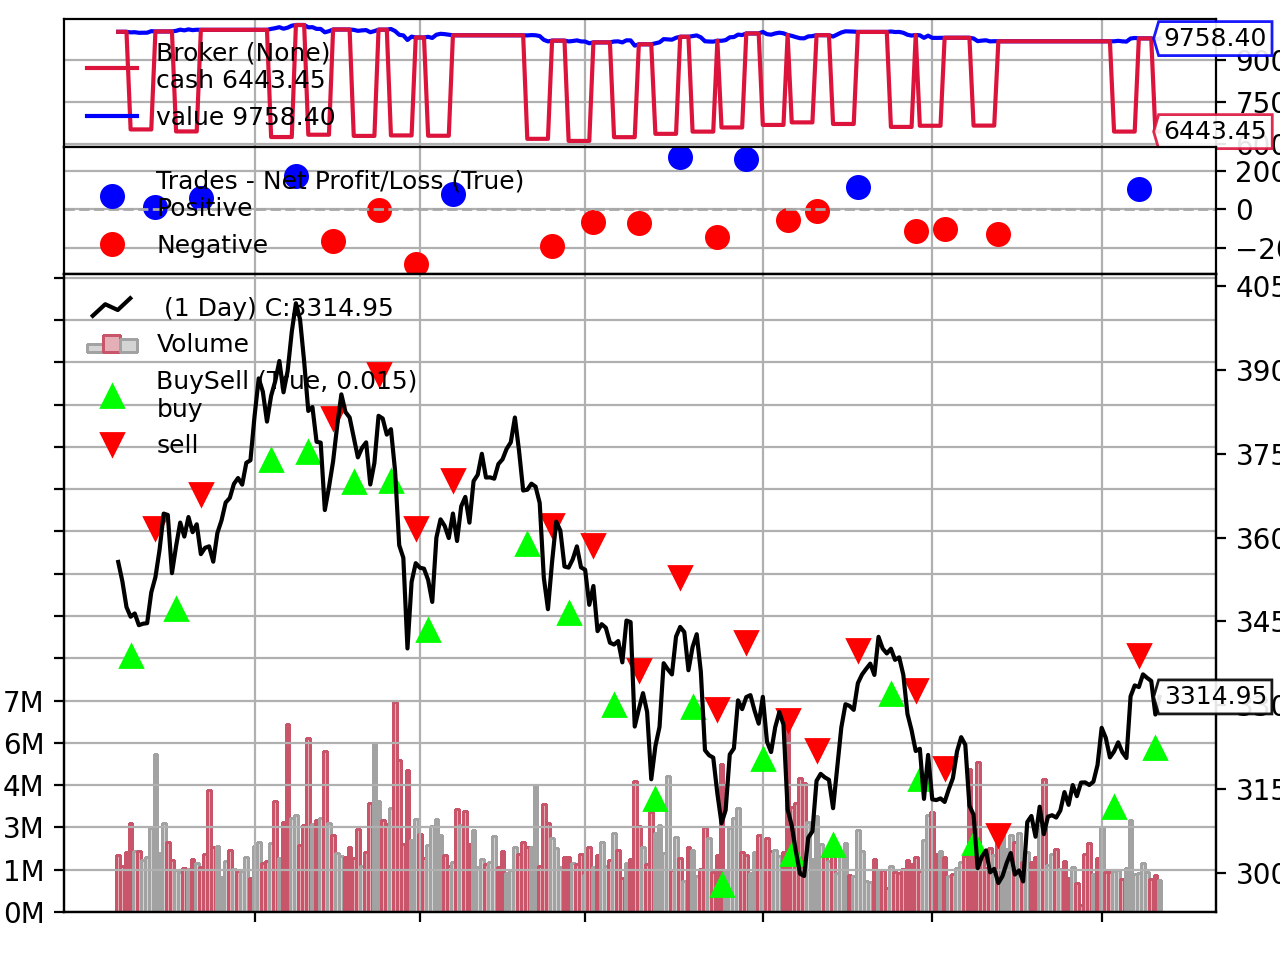

[[<Figure size 640x480 with 4 Axes>]]

In [84]:
cerebro.plot()